***<h1 style="text-align: center;">Final Project for<br>DTSA 5509 Introduction to Machine Learning:<br>Supervised Learning</h1>***

***<p style="text-align: center;">by Ryan Ordonez</p>***

***

 <h2 align="center">Fantasy Football Point Predictor</h2>

### Step 1: Gather data

In [1]:
# Install necessary libraries
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q matplotlib
# !pip install -q seaborn
# !pip install -q spicy

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Define the Problem

Problem Statement:
I have always had issues determining the correct players to draft for the upcoming NFL Fantasy Football season.
The goal of this project is to predict the fantasy football points a player will score in the upcoming 2024 season based on historical data from the 2019-2023 seasons.
It will then rank these players in order of fantasy football projected points so I can draft the best available person every round.
This proposed projection will be better than other widely used analysis tools as I will incorporate new features and more dynamic ML models to predicts the correct points per game by each player.

# Collect the Data

- The data for this project includes player statistics and fantasy points scored per game for the 2019, 2020, 2021, and 2023 seasons. 
- The data was obtained from two different sources.
- The first being from Kaggle at: https://www.kaggle.com/datasets/dtrade84/nfl-offensive-stats-2019-2022
- The second being from fantasydata.com at:  https://sportsdata.io/members/download-file?product=1389b51c-eb37-4fed-adaa-118c147dad4d
<br>I was required to pay a small price for the 2023 dataset so I will be adding it to my GitHub repo for this project. 


In [3]:
# Load the data
# Replace 'data_file_path.csv' with the actual file path of your dataset
data_file_path1 = 'https://raw.githubusercontent.com/RyanOrdonez/DTSA-5509-Introduction-to-Machine-Learning-Supervised-Learning-Final-Project/main/nfl_offensive_stats.csv'
data1 = pd.read_csv(data_file_path1)
data_file_path2 = 'https://raw.githubusercontent.com/RyanOrdonez/DTSA-5509-Introduction-to-Machine-Learning-Supervised-Learning-Final-Project/main/PlayerGame.2023.csv'
data2 = pd.read_csv(data_file_path2)

In [4]:
# Fixing the column name with extra space in the first dataset
data1.rename(columns={'position ': 'position'}, inplace=True)

In [5]:
# Create a unique identifier in both datasets
data1['PlayerID'] = data1['player'].astype(str) + "_" + data1['position'].astype(str) + "_" + data1['team'].astype(str)
data2['PlayerID'] = data2['Name'].astype(str) + "_" + data2['Position'].astype(str) + "_" + data2['Team'].astype(str)

In [6]:
# REMOVE PRESEASON GAME DATA
# Filter out rows where 'SeasonType' is 2
data2 = data2[data2['SeasonType'] != 2]
# Drop the 'SeasonType' column
data2 = data2.drop(columns=['SeasonType'])

In [7]:
# List only the columns in each dataset to keep
columns_to_keep_data1 = [
    'PlayerID', 'game_date', 'player', 'position', 'team', 'pass_cmp', 'pass_att', 'pass_yds', 
    'pass_td', 'pass_rating', 'pass_int', 'rush_att', 'rush_yds', 'rush_td', 
    'targets', 'rec', 'rec_yds', 'rec_td', 'Total_SDP', 'vis_team', 'home_team', 
    'vis_score', 'home_score'
]
columns_to_keep_data2 = [
    'PlayerID', 'GameDate', 'Name', 'Position', 'Team', 'PassingCompletions', 'PassingAttempts', 
    'PassingYards', 'PassingTouchdowns', 'PassingRating', 'PassingInterceptions', 
    'RushingAttempts', 'RushingYards', 'RushingTouchdowns', 'ReceivingTargets', 
    'Receptions', 'ReceivingYards', 'ReceivingTouchdowns', 'FantasyPoints', 'Opponent', 
    'HomeOrAway'
]
data1 = data1[columns_to_keep_data1]
data2 = data2[columns_to_keep_data2]

In [8]:
# Fixing differenences in columns to be able to merge
# Create the 'Opponent' column
data1['Opponent'] = data1.apply(lambda row: row['home_team'] if row['team'] == row['vis_team'] else row['vis_team'], axis=1)
# Create the 'HomeOrAway' column
data1['HomeOrAway'] = data1.apply(lambda row: 'Away' if row['team'] == row['vis_team'] else 'Home', axis=1)
# Dropping unnecessary columns from data1
data1.drop(columns=['vis_team', 'home_team', 'vis_score', 'home_score'], inplace=True)

In [9]:
# Renaming columns in data1 to match data2
data1.rename(columns={
    'game_date': 'GameDate',
    'player': 'Name',
    'position': 'Position',
    'team': 'Team',
    'pass_cmp': 'PassingCompletions',
    'pass_att': 'PassingAttempts',
    'pass_yds': 'PassingYards',
    'pass_td': 'PassingTouchdowns',
    'pass_rating': 'PassingRating',
    'pass_int': 'PassingInterceptions',
    'rush_att': 'RushingAttempts',
    'rush_yds': 'RushingYards',
    'rush_td': 'RushingTouchdowns',
    'targets': 'ReceivingTargets',
    'rec': 'Receptions',
    'rec_yds': 'ReceivingYards',
    'rec_td': 'ReceivingTouchdowns',
    'Total_SDP': 'FantasyPoints'
}, inplace=True)

In [10]:
# Suppressing the warning
warnings.filterwarnings("ignore", category=UserWarning)

# Preprocess the 'GameDate' column in both datasets
data1['GameDate'] = pd.to_datetime(data1['GameDate']).dt.strftime('%m/%d/%Y')
data2['GameDate'] = pd.to_datetime(data2['GameDate']).dt.strftime('%m/%d/%Y')

In [11]:
# Merging the data with preference for data1 values
merged_data = data1.combine_first(data2)
merged_data['GameDate'] = pd.to_datetime(merged_data['GameDate'], format='%m/%d/%Y')


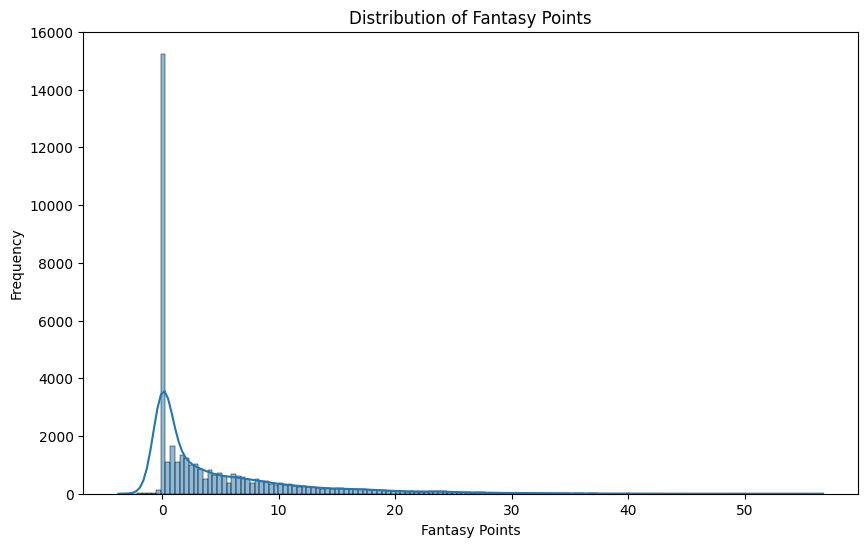

In [12]:
# Histogram of Fantasy Points
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['FantasyPoints'], kde=True)
plt.title('Distribution of Fantasy Points')
plt.xlabel('Fantasy Points')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Check if fantasy points are zero
zero_fp_mask = merged_data['FantasyPoints'] == 0

# Check if passing, rushing, or receiving attempts are nonzero
nonzero_attempts_mask = (
    (merged_data['PassingAttempts'] != 0) |
    (merged_data['RushingAttempts'] != 0) |
    (merged_data['ReceivingTargets'] != 0)
)

# Combine the masks
remove_rows_mask = zero_fp_mask & ~nonzero_attempts_mask

# Remove rows where fantasy points are zero and at least one of the attempts columns is nonzero
prefiltered = merged_data[~remove_rows_mask]

# List of offensive positions
offensive_positions = ['QB', 'RB', 'WR', 'TE', 'FB', 'HB', 'FB/D', 'FB/R', 'RB/W', 'WR/R']

# Filter the dataset to keep only offensive positions
filtered_data = prefiltered[prefiltered['Position'].isin(offensive_positions)]


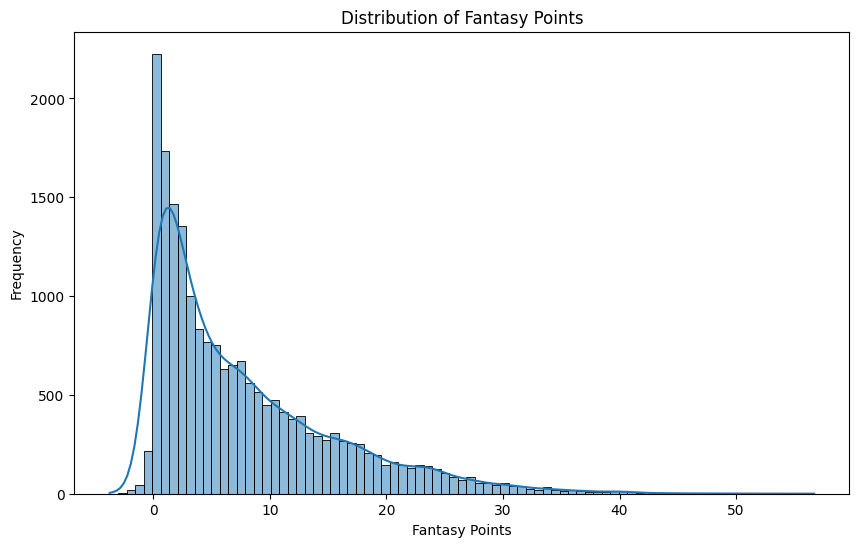

In [14]:
# Histogram of Fantasy Points
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['FantasyPoints'], kde=True)
plt.title('Distribution of Fantasy Points')
plt.xlabel('Fantasy Points')
plt.ylabel('Frequency')
plt.show()

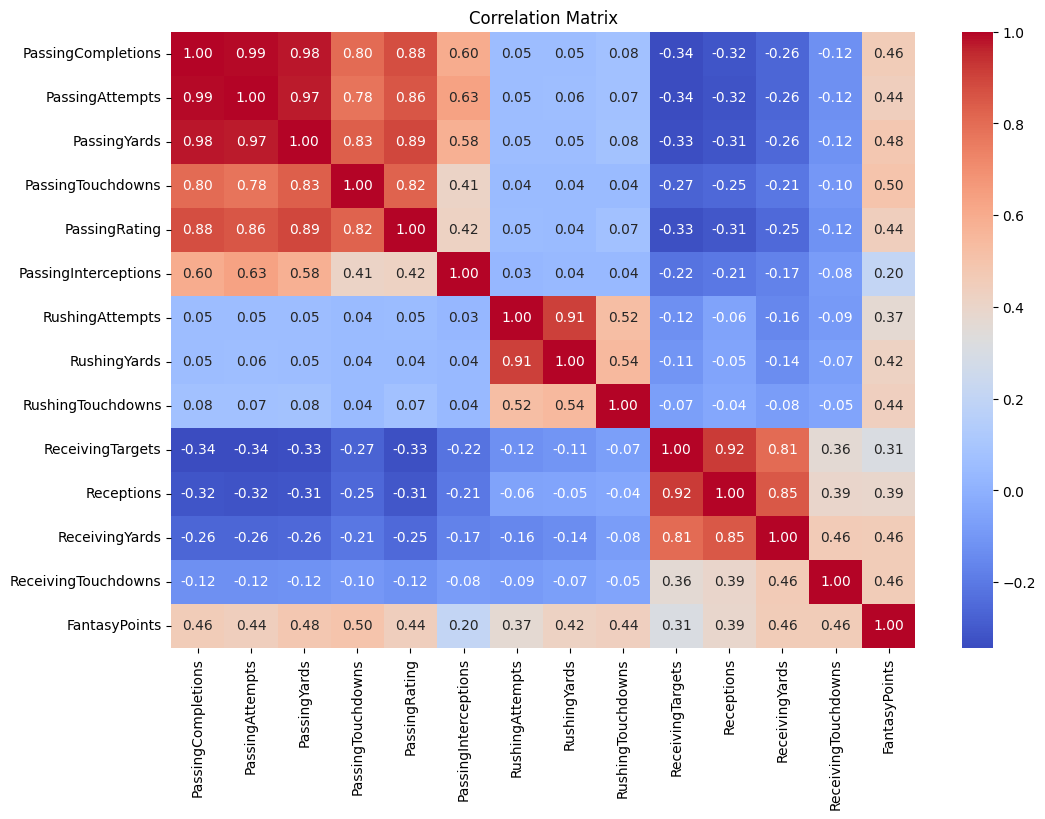

In [15]:
# Selecting only numeric columns for correlation analysis
numeric_cols = filtered_data.select_dtypes(include='number')

# Correlation matrix with Fantasy Points
correlation_matrix = numeric_cols.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [16]:
# Identifying outliers in Fantasy Points using the IQR method
Q1 = merged_data['FantasyPoints'].quantile(0.25)
Q3 = merged_data['FantasyPoints'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = merged_data[(merged_data['FantasyPoints'] < lower_bound) | (merged_data['FantasyPoints'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

# Optionally, remove outliers
merged_data = merged_data[(merged_data['FantasyPoints'] >= lower_bound) & (merged_data['FantasyPoints'] <= upper_bound)]


Number of outliers: 2608


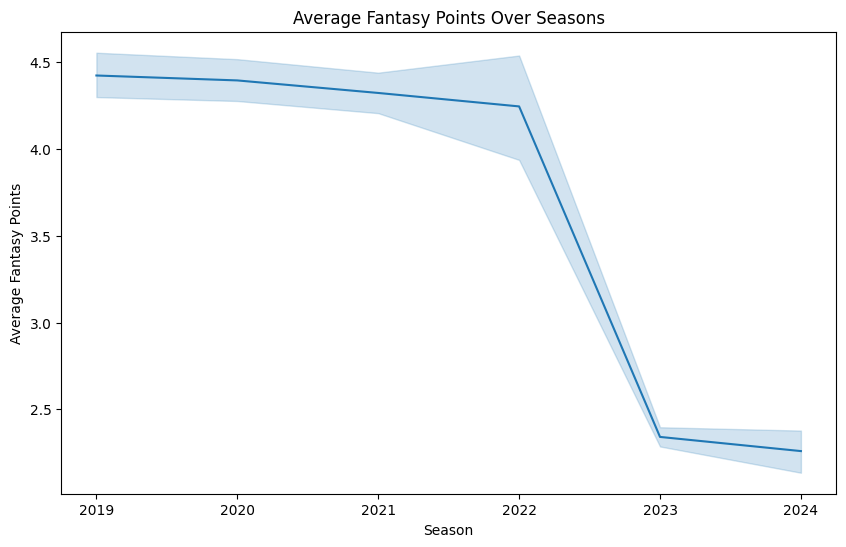

In [17]:
# Extracting year from GameDate for season analysis
merged_data['Season'] = pd.to_datetime(merged_data['GameDate']).dt.year

# Plotting Fantasy Points over seasons
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Season', y='FantasyPoints', estimator='mean')
plt.title('Average Fantasy Points Over Seasons')
plt.xlabel('Season')
plt.ylabel('Average Fantasy Points')
plt.show()


In [18]:
from scipy import stats

# Select numeric columns for outlier detection
numeric_columns = ['PassingCompletions', 'PassingAttempts', 'PassingYards', 'PassingTouchdowns',
                   'PassingRating', 'PassingInterceptions', 'RushingAttempts', 'RushingYards',
                   'RushingTouchdowns', 'ReceivingTargets', 'Receptions', 'ReceivingYards',
                   'ReceivingTouchdowns', 'FantasyPoints']

# Calculate z-score for each numeric column
z_scores = stats.zscore(filtered_data[numeric_columns])

# Define threshold for z-score
z_score_threshold = 3

# Identify rows where any numeric column exceeds the threshold
outlier_mask = (np.abs(z_scores) > z_score_threshold).any(axis=1)

# Count the number of outliers
num_outliers = outlier_mask.sum()
print("Number of outliers:", num_outliers)


Number of outliers: 3280


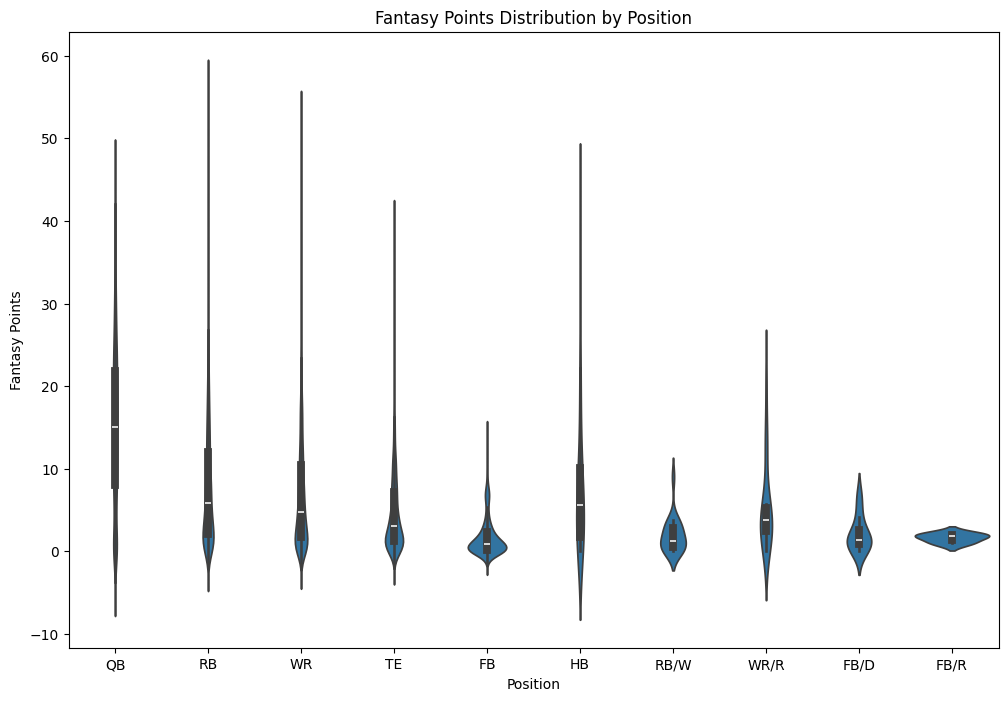

In [19]:
# Create a violin plot of fantasy points by position
plt.figure(figsize=(12, 8))
sns.violinplot(x='Position', y='FantasyPoints', data=filtered_data)
plt.title('Fantasy Points Distribution by Position')
plt.xlabel('Position')
plt.ylabel('Fantasy Points')
plt.show()


# Explore the Data
"""
Exploratory Data Analysis (EDA):
1. Visualize the distribution of fantasy points.
2. Explore correlations between different features and fantasy points.
3. Identify outliers and handle them if necessary.
4. Analyze trends over seasons.
"""

# Visualize the distribution of fantasy points
plt.figure(figsize=(10, 6))
sns.histplot(data['fantasy_points'], bins=20, kde=True)
plt.title('Distribution of Fantasy Points')
plt.xlabel('Fantasy Points')
plt.ylabel('Frequency')
plt.show()

# Explore correlations between different features and fantasy points
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Identify outliers and handle them if necessary
# Example: Plot boxplots for numerical features to identify outliers and use appropriate methods to handle them

# Analyze trends over seasons
# Example: Plot line graphs to visualize trends in fantasy points over different seasons

# Save the processed data
# Example: data.to_csv('processed_data.csv', index=False)

# Your exploration and analysis continue...



### Step 2: Identify a Supervised Machine Learning Problem

### Step 3: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

EDA Procedure Example 
- Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.

- Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.

- Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.

- Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.

- You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?

- If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.

### Step 4: Perform Analysis Using Supervised Machine Learning Models of your Choice, Present Discussion and Conclusions
- Start the main analysis such as classification or regression
- Use multiple models to compare
- Present Discussion
- Conclusions

### Step 5: Produce Deliverables: Jupyter Notebook Report, Video presentation, and GitHub Repository